In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../data/raw/Mall_Customers.csv")

In [3]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# ───────────────────────── 1. Basic cleaning ─────────────────────────
df = df.rename(columns=str.strip)           # remove any leading spaces
df = df.rename(columns={"Genre": "Gender"}) # keep naming consistent

In [6]:
# Encode Gender to feed to K-Means
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})

In [7]:
# drop CustomerID
features = df.drop(columns=["CustomerID"])

In [8]:
features

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# optional: wrap in a new DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)
X_scaled_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Explained variance per component
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

print(f"Explained variance ratio per PC: {explained.round(3)}")
print(f"Cumulative explained variance:    {cumulative.round(3)}")


Explained variance ratio per PC: [0.337 0.262]
Cumulative explained variance:    [0.337 0.599]


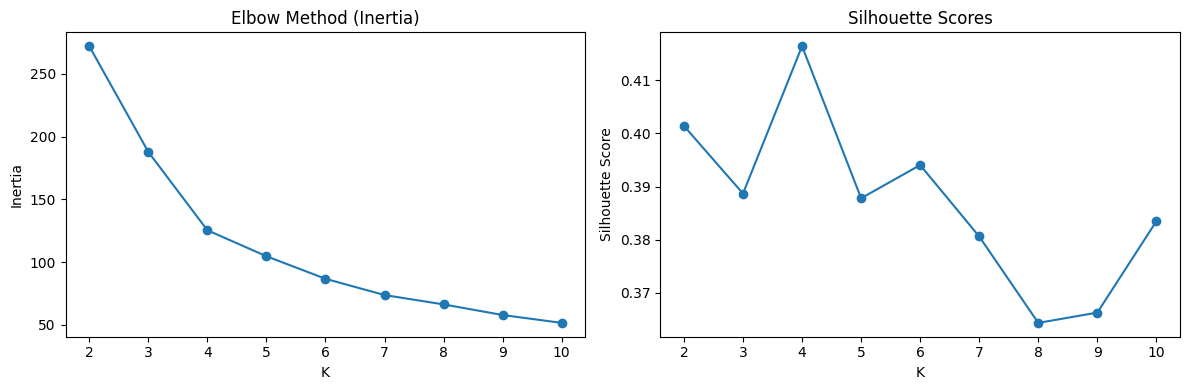

✅ Best K based on silhouette score: 4 (Score = 0.416)


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

Ks = range(2, 11)
inertias = []
sils = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    inertias.append(kmeans.inertia_)
    sils.append(silhouette_score(X_pca, labels))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Elbow
ax[0].plot(Ks, inertias, 'o-')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inertia')

# Silhouette
ax[1].plot(Ks, sils, 'o-')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Recommend best K based on silhouette
best_k = Ks[np.argmax(sils)]
print(f"✅ Best K based on silhouette score: {best_k} (Score = {max(sils):.3f})")

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

df["Cluster"]= cluster_labels

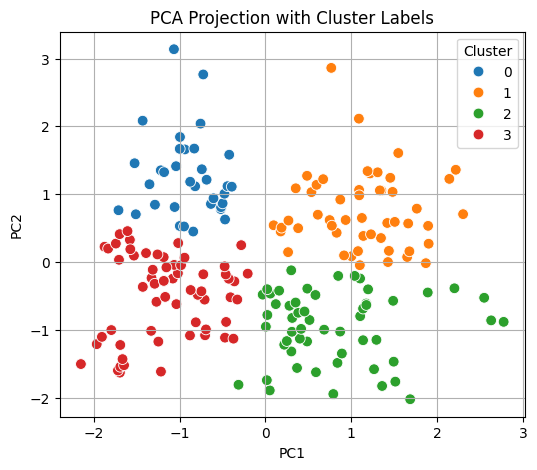

In [15]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df["Cluster"], palette="tab10", s=60)
plt.title("PCA Projection with Cluster Labels")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

In [16]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,1,19,15,39,3
1,2,1,21,15,81,3
2,3,0,20,16,6,2
3,4,0,23,16,77,3
4,5,0,31,17,40,2
...,...,...,...,...,...,...
195,196,0,35,120,79,0
196,197,0,45,126,28,1
197,198,1,32,126,74,0
198,199,1,32,137,18,1


In [17]:
summary = (
    df.groupby("Cluster")
      .agg(
         Count               = ("CustomerID", "count"),
         Female_Percent      = ("Gender", lambda x: (1 - x.mean()) * 100),  # 1 - mean(Male) = Female %
         Avg_Age             = ("Age", "mean"),
         Avg_Income_k        = ("Annual Income (k$)", "mean"),
         Avg_Spend_Score     = ("Spending Score (1-100)", "mean")
      )
      .round(1)
      .sort_values("Avg_Spend_Score", ascending=False)
)

summary["Female_Percent"] = summary["Female_Percent"].astype(str) + "%"
summary


,Count,Female_Percent,Avg_Age,Avg_Income_k,Avg_Spend_Score
Cluster,,,,,
0,34,17.6%,29.9,81.5,73.9
3,61,82.0%,27.3,49.8,67.5
2,54,87.0%,49.2,46.2,34.0
1,51,17.6%,47.6,74.6,30.9
